#Pengenalan

**Latar Belakang**

Ditengah wabah COVID-19 yang merubah normalitas proses pada tiap sektor di seluruh dunia, bidang medis dan kesehatan menjadi ujung tombak untuk permasalahan ini. Dengan jumlah kasus yang membludak, bukan hal yang mustahil untuk terjangkit wabah ini; dan jika demikian, rumah sakit menjadi tempat persinggahan untuk rawat inap. Berhubungan dengan biaya rawat inap ataupun penyembuhan pasien, perusahaan asuransi kesehatan sangat terikat dengan cost atau biaya penyembuhan. Oleh karna itu, tim finansial perusahaan asuransi sudah seharusnya membuat eksplorasi terhadap datanya. Pemilihan dataset ini berujung pada data "Personal medical cost dataset".

**Data**
(Medical Cost Personal Dataset)

Dataset Personal medical cost berisi data tentang jumlah dana yang harus dibayar berdasarkan variabel independennya, seperti umur, gender, pengaruh rokok, dan lainnya.

Variabel independen
- age/Umur (numerik)
- sex/j. kelamin (kategorik)
- body mass index (numerik)
- children/jumlah anak (numerik)
- smoker/perokok (kategorik)
- region/wilayah tinggal (kategorik)

Variabel dependen
- charges/biaya (numerik)

ref: https://www.kaggle.com/mirichoi0218/insurance

**Objektif**

Objektif dari eksplorasi dan pembuatan model ini adalah mengetahui perkiraan range biaya yang akan dibayar (oleh pihak asuransi) ketika model diinterferensi dengan sebuah tupel berisikan kumpulan variabel independen layaknya data awal.

#Importing library

In [1]:
import time as tm
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from math import floor
from pprint import pprint
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error

#Data Loading dan EDA

In [2]:
df = pd.read_csv('dataset/cost.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Check nilai null

In [3]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [4]:
df.isnull().any()

age         False
sex         False
bmi         False
children    False
smoker      False
region      False
charges     False
dtype: bool

Deskripsi statistik data

In [5]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


**Eksplorasi**

Distribusi biaya terhadap variabel umur, perokok, bmi, dan region

Dari visualisasi dibawah, terdapat gap sekitar 10rb USD untuk umur 18 tahun dengan 50 tahun keatas (pada scatter terbawah). Dapat disimpulkan bahwa semakin besar umur pasien maka semakin besar juga biaya yang harus dikeluarkan.

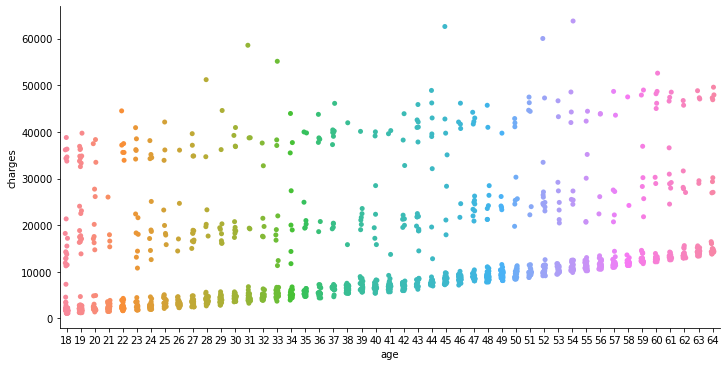

In [6]:
sns.catplot(data=df, x='age', y='charges', height=5, aspect=2)

Berikutnya adalah representasi distribusi biaya pada pasien perokok & non-perokok.

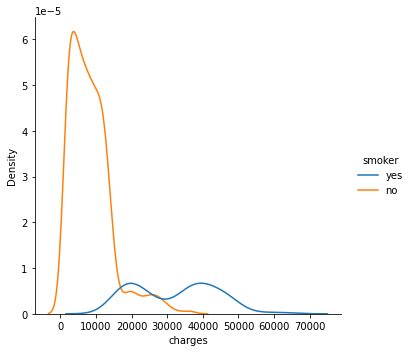

In [7]:
sns.displot(df, x="charges", kind="kde", hue='smoker')

Jika kedua plot sebelumnya digabung maka akan menghasilkan visualisasi seperti dibawah, yang memberikan kejelasan bahwa biaya yang dikeluarkan oleh pasien dapat dipangkas jika pasien tersebut tidak merokok.

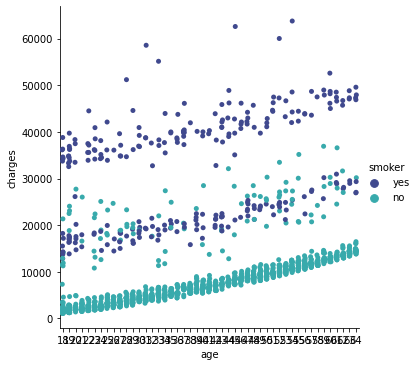

In [8]:
sns.catplot(data=df, x='age', y='charges', palette='mako', hue='smoker')

Kemudian distribusi bmi terhadap biaya medis adalah sebagai berikut

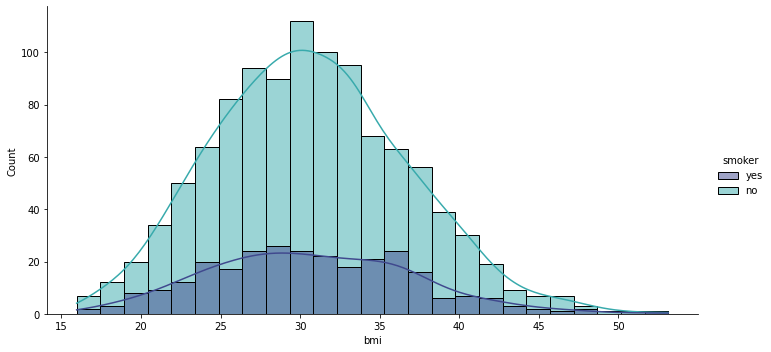

In [9]:
sns.displot(data=df, x='bmi', palette='mako', height=5, aspect=2, kde=True, hue='smoker')

Persebaran region atau wilayah tempat tinggal dari pasien

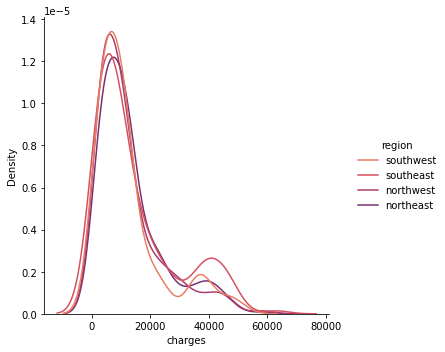

In [10]:
sns.displot(data=df, x='charges', palette='flare',kind='kde', hue='region')

Dari plot diatas, terlihat bahwa wilayah tempat pasien tinggal hanya sedikit berpengaruh terhadap biaya yang dikeluarkan selama perawatan. Perbedaan yang jelas terlihat pada rentang 30rb sampai 50rb.

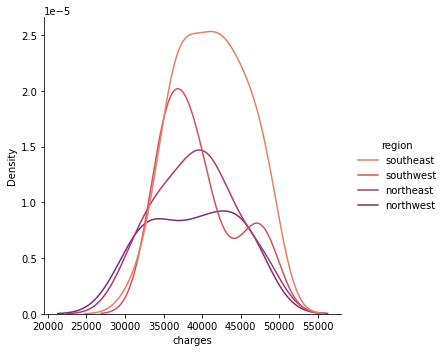

In [11]:
dfs = df[(df.charges>30000)]
dfs = dfs[(dfs.charges<50000)]
sns.displot(data=dfs, x='charges', palette='flare',kind='kde', hue='region')

**Distribusi umur berdasarkan gender**

Pada range usia muda sampai dewasa, jumlah laki-laki lebih unggul. Sedangkan pada range usia lanjut, terlihat jumlah perempuan yang lebih banyak. Juga data terbanyak diperoleh dari rentang usia 18 sampai usia kurang dari 30.

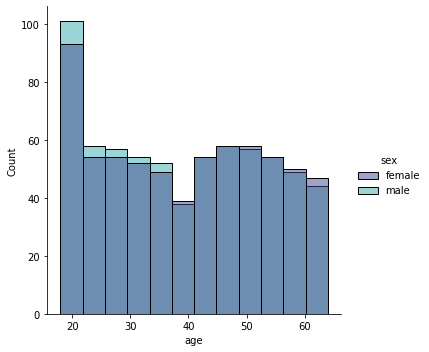

In [12]:
sns.displot(x='age', hue = 'sex', palette='mako', data=df)

**Distribusi kepemilikan anak berdasarkan region dan pengaruhnya terhadap biaya**

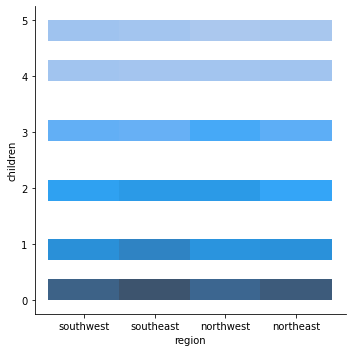

In [13]:
sns.displot(data=df, y='children', x='region', palette='mako')

Visualisasi berikutnya adalah pengaruh jumlah anak terhadap biaya, terlihat pula keduanya tidak terlalu berkorelasi

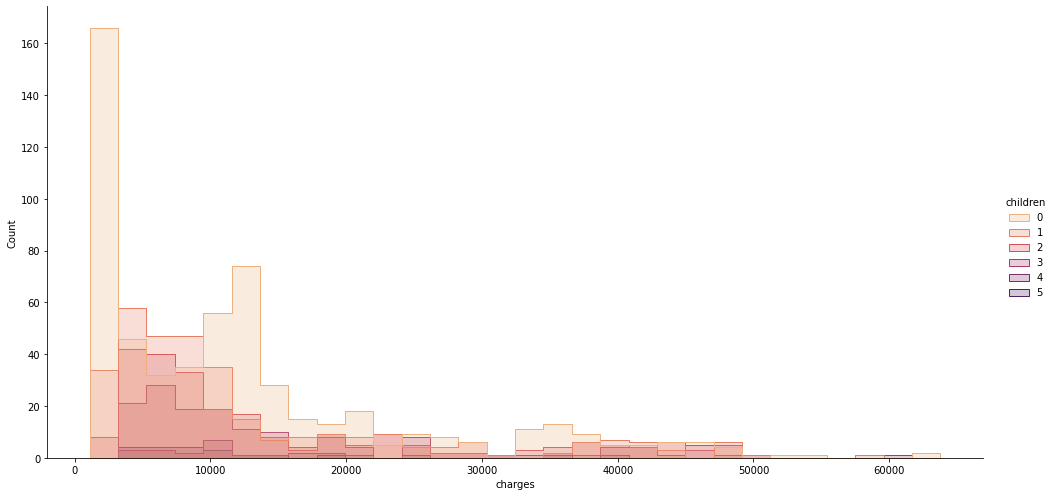

In [14]:
sns.displot(data=df, x="charges", hue="children", height=7, aspect=2, element='step', palette='flare')

#Data Preprocessing

**Encoding**

Dilakukan untuk merubah fitur independen ke dalam bentuk numerik

In [15]:
le = preprocessing.LabelEncoder()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


- **Sex/jenis kelamin**

In [16]:
df['sex'].value_counts()

male      676
female    662
Name: sex, dtype: int64

In [17]:
dfn = pd.get_dummies(df, columns=['sex'])
dfn

,age,bmi,children,smoker,region,charges,sex_female,sex_male
0,19,27.900,0,yes,southwest,16884.92400,1,0
1,18,33.770,1,no,southeast,1725.55230,0,1
2,28,33.000,3,no,southeast,4449.46200,0,1
3,33,22.705,0,no,northwest,21984.47061,0,1
4,32,28.880,0,no,northwest,3866.85520,0,1
...,...,...,...,...,...,...,...,...
1333,50,30.970,3,no,northwest,10600.54830,0,1
1334,18,31.920,0,no,northeast,2205.98080,1,0
1335,18,36.850,0,no,southeast,1629.83350,1,0
1336,21,25.800,0,no,southwest,2007.94500,1,0


- **Smoker/perokok**


In [18]:
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [19]:
dfm = pd.get_dummies(dfn, columns=['smoker'])
dfm

,age,bmi,children,region,charges,sex_female,sex_male,smoker_no,smoker_yes
0,19,27.900,0,southwest,16884.92400,1,0,0,1
1,18,33.770,1,southeast,1725.55230,0,1,1,0
2,28,33.000,3,southeast,4449.46200,0,1,1,0
3,33,22.705,0,northwest,21984.47061,0,1,1,0
4,32,28.880,0,northwest,3866.85520,0,1,1,0
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,northwest,10600.54830,0,1,1,0
1334,18,31.920,0,northeast,2205.98080,1,0,1,0
1335,18,36.850,0,southeast,1629.83350,1,0,1,0
1336,21,25.800,0,southwest,2007.94500,1,0,1,0


- **Region/wilayah tempat tinggal**

In [20]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [21]:
dfm['region']= le.fit_transform(dfm['region'])
dfm

,age,bmi,children,region,charges,sex_female,sex_male,smoker_no,smoker_yes
0,19,27.900,0,3,16884.92400,1,0,0,1
1,18,33.770,1,2,1725.55230,0,1,1,0
2,28,33.000,3,2,4449.46200,0,1,1,0
3,33,22.705,0,1,21984.47061,0,1,1,0
4,32,28.880,0,1,3866.85520,0,1,1,0
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,1,10600.54830,0,1,1,0
1334,18,31.920,0,0,2205.98080,1,0,1,0
1335,18,36.850,0,2,1629.83350,1,0,1,0
1336,21,25.800,0,3,2007.94500,1,0,1,0


**Pembagian dataset**

Menjadi 2 bagian: x (kumpulan variabel independen) dan y (variabel dependen)

In [22]:
scaler = StandardScaler()

In [23]:
x = dfm[['age', 'bmi', 'children', 'region', 'sex_female', 'sex_male', 'smoker_no', 'smoker_yes']]
y = dfm[['charges']]

**Train-Dev/Validation-Test split**

Dengan ketentuan
- Data test adalah 10% dari data awal
- Data train adalah 90% dari data awal
- Data train dikurang sebesar 20% untuk dijadikan data validasi/dev

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=42)
x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size=0.20, random_state=42)

In [25]:
print("train",{x_train.shape},{y_train.shape})
print("dev", {x_dev.shape},{y_dev.shape})
print("test", {x_test.shape},{y_test.shape})

train {(963, 8)} {(963, 1)}
dev {(241, 8)} {(241, 1)}
test {(134, 8)} {(134, 1)}


**Standarisasi variabel**

Penerapan standarisasi pada seluruh variabel independen, hal ini dilakukan agar nilai dengan tipe data kategorik dapat dijadikan parameter regresi nantinya.

In [26]:
# x_train = scaler.fit_transform(x_train)
# x_dev = scaler.fit_transform(x_dev)
# x_test = scaler.fit_transform(x_test)

#Model Definition

Arsitektur model regresi yang akan digunakan adalah Random Forest Regression. Pemilihan model ini didasari oleh beberapa hal, diantaranya:
- Jumlah feature tidak banyak
- Data tidak selamanya linear
- Random Forest tidak butuh transformasi lebih lanjut seperti log transformation
- Bisa digunakan tanpa menghilangkan outlier

Berikut ini adalah model RF Regressor biasa dan parameternya

In [27]:
rf_default = RandomForestRegressor(n_estimators=10, random_state = 42)
pprint(rf_default.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


Hyperparameter yang akan digunakan untuk model adalah:
- jumlah estimator
- max feature
- max depth
- min samples split
- min samples leaf
- bootstrap

In [28]:
n_estimators = [4, 8, 16, 32, 64]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [4, 8, 16, 32, 64]}


Grid hyperparameter diatas akan digunakan untuk menentukan parameter mana saja yang dapat mempengaruhi model untuk mendapatkan model terbaik

In [29]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

Dari proses model definition, terdapat dua model yang akan dilatih dan dievaluasi:
- Model 1: Model default Random Forest dengan random state = 42
- Model 2: Model Random Forest dengan hyperparameter yang telah ditentukan pada grid, dan memakai cross validation

#Model Training

In [30]:
# Model 1
start = tm.time()
rf_default.fit(x_train, y_train)
stop = tm.time()
time1 = (stop - start)*1000
time1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


65.22607803344727

In [31]:
# Model 2
start = tm.time()
rf_random.fit(x_train, y_train)
stop = tm.time()
time2 = (stop - start)*1000
time2

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   15.3s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


15506.93154335022

**Parameter terbaik model 2**

Karena memakai metode cross validation, terdapat beberapa model dengan parameter yang berbeda pula.

Parameter terbaik yang dapat diperoleh dari grid sebelumnya untuk model Random Forest adalah:

In [32]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 64}

**Parameter model 1**

In [33]:
rf_default.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

#Model Evaluation

Fungsi untuk evaluasi model

In [34]:
def regression_results(y_true, y_pred):

    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))
    print('r2 Score: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

    return round(r2,4), round(mean_absolute_error, 4), round(mse, 4)

**Fitting model 1**

In [35]:
prediction_default = rf_default.predict(x_test)
a1, a2, a3 = regression_results(y_test, prediction_default)

explained_variance:  0.8056
r2 Score:  0.8024
MAE:  2851.3115
MSE:  27262679.0485
RMSE:  5221.3675


**Fitting model 2**

In [36]:
prediction_random = rf_random.predict(x_test)
b1, b2, b3 = regression_results(y_test, prediction_random)

explained_variance:  0.8658
r2 Score:  0.8648
MAE:  2411.7806
MSE:  18651958.3944
RMSE:  4318.7913


**Visualisasi**

In [37]:
data = [['default', a1*100, a2, a3, rf_default.get_params()['n_estimators'], round(time1, 2)],
        ['random_grid', b1*100, b2, b3, rf_random.best_params_['n_estimators'], round(time2, 2)]]
performance_df = pd.DataFrame(data, columns = [
    'model',
    'score',
    'mean_avg_err',
    'mean_squared_err',
    'n_estimators',
    'time(ms)'
    ])
performance_df

,model,score,mean_avg_err,mean_squared_err,n_estimators,time(ms)
0,default,80.24,2851.3115,2.726268e+07,10,65.23
1,random_grid,86.48,2411.7806,1.865196e+07,64,15506.93


**Mean Average Error (MAE) Comparison**

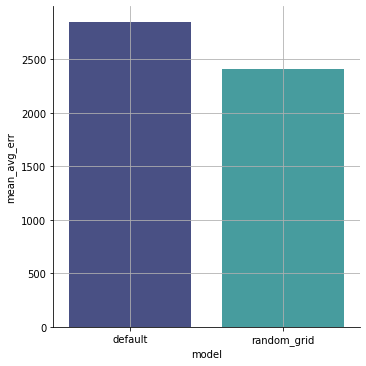

In [38]:
g = sns.catplot(data=performance_df, y='mean_avg_err', x='model', palette='mako', kind='bar')
plt.grid()
plt.show()

**Mean Squared Error (MSE) Comparison**

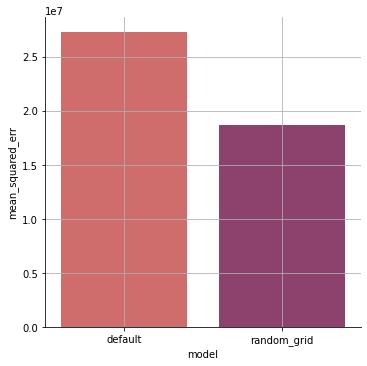

In [39]:
g = sns.catplot(data=performance_df, y='mean_squared_err', x='model', palette='flare', kind='bar')
plt.grid()
plt.show()

**Training time**

In [40]:
data = [['default', 'start', 0],
        ['default', 'end', round(time1, 2)],
        ['random_grid', 'start', 0],
        ['random_grid', 'end', round(time2, 2)]]
time_df = pd.DataFrame(data, columns = [
    'model',
    'type_time',
    'time_stamp',
    ])
time_df

,model,type_time,time_stamp
0,default,start,0.00
1,default,end,65.23
2,random_grid,start,0.00
3,random_grid,end,15506.93


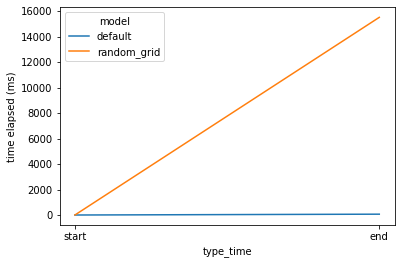

In [41]:
g = sns.lineplot(data=time_df, y='time_stamp', x="type_time", hue="model")
plt.ylabel("time elapsed (ms)")
plt.show()

**R2/Accuracy Score Comparison**

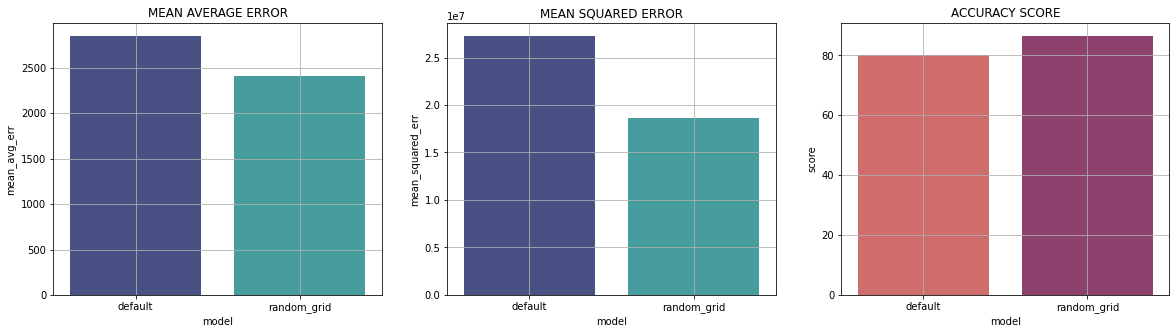

In [42]:
fig, axs = plt.subplots(figsize=(20, 5), ncols=3)
g = sns.barplot(x='model', y='mean_avg_err', data=performance_df, ax=axs[0], palette='mako')
axs[0].grid()
axs[0].set_title('MEAN AVERAGE ERROR')
g = sns.barplot(x='model', y='mean_squared_err', data=performance_df, ax=axs[1], palette='mako')
axs[1].grid()
axs[1].set_title('MEAN SQUARED ERROR')
g = sns.barplot(x='model', y='score', data=performance_df, ax=axs[2], palette='flare')
axs[2].grid()
axs[2].set_title('ACCURACY SCORE')
plt.show()

#Model Saving

Dengan menggunakan library pickle, model regresi random akan disimpan

In [43]:
pickle.dump(rf_random, open('model.pkl','wb'))

#Model Inference

Pembuatan data

In [44]:
inf_data = [
            [45, 27.175, 1, 0, 1, 0, 0, 1],
            [18, 25.175, 0, 1, 0, 1, 1, 0],
            [23, 22.175, 2, 2, 0, 1, 0, 1],
            [50, 30.175, 4, 3, 0, 1, 0, 1],
            [60, 28.175, 3, 0, 1, 0, 1, 0],
]
inf_data

[[45, 27.175, 1, 0, 1, 0, 0, 1],
 [18, 25.175, 0, 1, 0, 1, 1, 0],
 [23, 22.175, 2, 2, 0, 1, 0, 1],
 [50, 30.175, 4, 3, 0, 1, 0, 1],
 [60, 28.175, 3, 0, 1, 0, 1, 0]]

In [45]:
predictions = rf_random.predict(inf_data)
for i in range(0,len(inf_data)):
    print(f'data: {inf_data[i]} - charges prediction: {predictions[i]:.2f}')

data: [45, 27.175, 1, 0, 1, 0, 0, 1] - charges prediction: 26271.67
data: [18, 25.175, 0, 1, 0, 1, 1, 0] - charges prediction: 1781.59
data: [23, 22.175, 2, 2, 0, 1, 0, 1] - charges prediction: 16465.81
data: [50, 30.175, 4, 3, 0, 1, 0, 1] - charges prediction: 43822.18
data: [60, 28.175, 3, 0, 1, 0, 1, 0] - charges prediction: 15213.25


#Kesimpulan

Dari proses awal sampai akhir, telah diciptakan sebuah model yang dapat melakukan prediksi. Tujuan prediksi ini melakukan perkiraan biaya yang akan ditanggung oleh pihak asuransi kesehatan.

Dengan demikian, objektif yang ditetapkan sebelumnya telah tercapai.


Summary:
- Topik: **Regresi**
- Dataset: **Medical Cost Personal Dataset**
- Ukuran Dataset: **7 fitur x 1338 baris**
- Model: **Random Forest Regression** dengan Random Grid hyperparameter
- Akurasi Model: **86.31%**